# Machine Learning Engineer Nanodegree
## Model Evaluation & Validation
## Project: Predicting Boston Housing Prices

## Getting Started
In this project, you will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

## Dataset
The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

In [47]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
In this first section of this project, you will make a cursory investigation about the Boston housing data and provide your observations. Familiarizing yourself with the data through an explorative process is a fundamental practice to help you better understand and justify your results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Calculate Statistics
You will calculate descriptive statistics about the Boston housing prices. Since `numpy` has already been imported for you, use this library to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


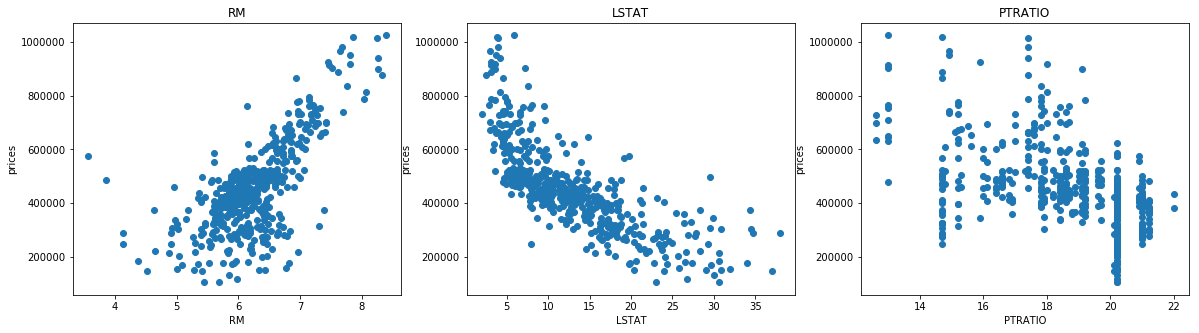

In [48]:
import matplotlib.pyplot as plt

# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

# make plots for better obervation of the dataset
plt.figure(figsize=(20,5))
for i,col in enumerate(features.columns):
    plt.subplot(1,3,i+1)
    plt.plot(data[col],prices,'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')


### Question 1 - Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.


** Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? Justify your answer for each.**

**Hint:** This problem can phrased using examples like below.  
* Would you expect a home that has an `'RM'` value(number of rooms) of 6 be worth more or less than a home that has an `'RM'` value of 7?
* Would you expect a neighborhood that has an `'LSTAT'` value(percent of lower class workers) of 15 have home prices be worth more or less than a neighborhood that has an `'LSTAT'` value of 20?
* Would you expect a neighborhood that has an `'PTRATIO'` value(ratio of students to teachers) of 10 have home prices be worth more or less than a neighborhood that has an `'PTRATIO'` value of 15?

**Answer: **

1) An increase in RM would lead to an increase in MEDV, because the more rooms, the larger house, more expensive.

2) An increase in LSTAT would lead to an decrease in MEDV, because lower class workers have limited capbility of affording expensive houses.

3) An increase in PTRATIO would lead to an decrease in MEDV, because high PTRATIO means more students share a teacher, which is an indication of lower housing price in the neighbourhood.


----

## Developing a Model
In this second section of the project, you will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

In [49]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    #Reviewer's suggestion
    y_true_mean = np.mean(y_true)
    SSres = sum(np.square(np.subtract(y_true, y_predict)))
    SStot = sum(np.square(np.subtract(y_true, y_true_mean)))
    score_1 = 1.0 - SSres/SStot
    
    # Return the score
    return score_1
    

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |


Model has a coefficient of determination, R^2, of 0.923.


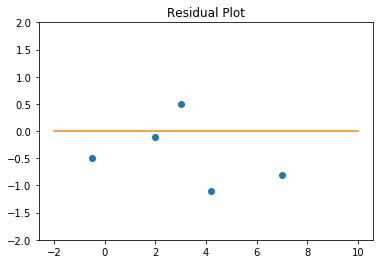

In [50]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

#Residual plot
trueValues = [3, -0.5, 2, 7, 4.2]
predictions = [2.5, 0.0, 2.1, 7.8, 5.3]
residuals = [i-j for i,j in zip(trueValues, predictions)]
plt.plot(trueValues, residuals,'o',[-2,10],[0,0],'-')
plt.ylim(-2,2)
plt.title('Residual Plot')


* Would you consider this model to have successfully captured the variation of the target variable? 
* Why or why not?

** Hint: **  The R2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable. In other words:
* R2 score of 0 means that the dependent variable cannot be predicted from the independent variable.
* R2 score of 1 means the dependent variable can be predicted from the independent variable.
* R2 score between 0 and 1 indicates the extent to which the dependent variable is predictable. An 
* R2 score of 0.40 means that 40 percent of the variance in Y is predictable from X.

**Answer:**

I would consider this model successfully captured the variation of the target variable. The model's coefficient of dertermination is 0.923, which means 92 percent of the variance in dependent variable is predictable from the independent variables. 

According to the Reviewer's suggestion, R-squared equals model explained variation divided by total variation. I have tried another method based on this concept, and got the same R-squared value. 

More data points would allow us to be more confident in the model. However, the R2 score may be higher or lower after adding more data points.

### Shuffle and Split Data
Your next implementation requires that you take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In [51]:
# Import 'train_test_split'
from sklearn.cross_validation import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size = 0.20, random_state = 29)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


### Question 3 - Training and Testing

* What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?

**Hint:** Think about how overfitting or underfitting is contingent upon how splits on data is done.

**Answer: **

Our goal is to build a model with good generalization instead of memorization.

1) The testing subsets provide honest assessments of the performance of the predictive models.

2) The testing subsets also actively select the best model from a set of alternative models.

3) If the dataset is well shuffled and split, the overfitting or underfitting problem of the model would be quite consistent.

----

## Analyzing Model Performance
In this third section of the project, you'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, you'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

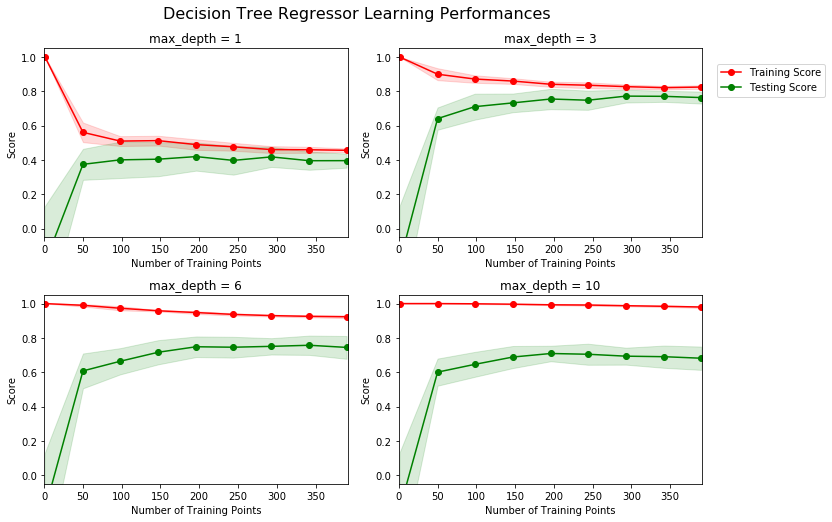

In [52]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)


### Question 4 - Learning the Data
* Choose one of the graphs above and state the maximum depth for the model. 
* What happens to the score of the training curve as more training points are added? What about the testing curve? 
* Would having more training points benefit the model? 

**Hint:** Are the learning curves converging to particular scores? Generally speaking, the more data you have, the better. But if your training and testing curves are converging with a score above your benchmark threshold, would this be necessary?
Think about the pros and cons of adding more training points based on if the training and testing curves are converging.

**Answer: **

I choose the graph with max_depth of 3. 

As in the initial phases, the training score gets lower and the testing score gets higher, because there was very small number of training points that we simply memorize the training data (no generalization). The training score is 1 or close due to model overfitting. The testing score is 0 or close.

Then as more training points added, training score drops because the model cannot explain all the variance anymore. It converges to a value about 0.8. Testing score increases rapidly and converges to a value about 0.8 as well. This means that the model starts to generalize better. The convergent score of training curve is higher than that of testing curve. 

Within certain number of training points, the more training points, the better the model scores. Beyond certain amount, adding more training points does not contribute much to the model's score.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

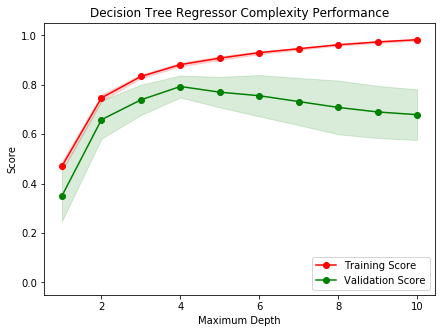

In [53]:
vs.ModelComplexity(X_train, y_train)


### Question 5 - Bias-Variance Tradeoff
* When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? 
* How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?

**Hint:** High bias is a sign of underfitting(model is not complex enough to pick up the nuances in the data) and high variance is a sign of overfitting(model is by-hearting the data and cannot generalize well). Think about which model(depth 1 or 10) aligns with which part of the tradeoff.

**Answer: **

The model trained with a maximum depth of 1 suffers from high bias, which is underfitting. Because both the training score and the validation score is very low. The model does not fully make use of the training data, and oversimplifies the data. 

The model trained with a maximum depth of 10 suffers from high variance, which is overfitting. Because there is a large gap between the training score and the validation score, which means the model only memorizes the training data and fails to generalize well to new unseen data.

### Question 6 - Best-Guess Optimal Model
* Which maximum depth do you think results in a model that best generalizes to unseen data? 
* What intuition lead you to this answer?

** Hint: ** Look at the graph above Question 5 and see where the validation scores lie for the various depths that have been assigned to the model. Does it get better with increased depth? At what point do we get our best validation score without overcomplicating our model? And remember, Occams Razor states "Among competing hypotheses, the one with the fewest assumptions should be selected."

**Answer: **

The model with maximum depth of 4 results in a model that best generalizes the unseen data, because it gets the highest validation score.  

-----

## Evaluating Model Performance
In this final section of the project, you will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7 - Grid Search
* What is the grid search technique?
* How it can be applied to optimize a learning algorithm?

** Hint: ** When explaining the Grid Search technique, be sure to touch upon why it is used,  what the 'grid' entails and what the end goal of this method is. To solidify your answer, you can also give an example of a parameter in a model that can be optimized using this approach.

**Answer: **

The grid Search technique allows you to define a grid of parameters that will be searched using k-fold cross-validataion. 

There are mainly two kinds of grid search in sklearn. The GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter.
The RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values.

### Question 8 - Cross-Validation

* What is the k-fold cross-validation training technique? 

* What benefit does this technique provide for grid search when optimizing a model?

**Hint:** When explaining the k-fold cross validation technique, be sure to touch upon what 'k' is, how the dataset is split into different parts for training and testing and the number of times it is run based on the 'k' value.

When thinking about how k-fold cross validation helps grid search, think about the main drawbacks of grid search which are hinged upon **using a particular subset of data for training or testing** and how k-fold cv could help alleviate that. You can refer to the [docs](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) for your answer.

**Answer: ** 

The training set is randomly shuffled and then split into k equal-sized subsets. A model is trained using k-1 of the folds as training data. The resulting model is validated on the remaining part of the data. Repeat the process k-1 times with each of the k-1 subsets used exactly once as the validation data. The average error of the k trials produces a single estimation of the model.

The advantage of k-fold technique is that all observations are used for both training and validation, and each observation is used for validation exactly once and for testing k-1 times. It makes full use of the information contained within the observations. The variance of the resulting estimate is reduced as k is increased. 

The disadvantage of this method is that the training algorithm has to be rerun from scratch k times, which means it takes k times as much computation to make an evaluation. 

10-fold cross-validation is commonly used, but in general k remains an unfixed parameter.

### Implementation: Fitting a Model
Your final implementation requires that you bring everything together and train a model using the **decision tree algorithm**. To ensure that you are producing an optimized model, you will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, you will find your implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique you describe in **Question 8**, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While you're working on your implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

In [54]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV


def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    # From Reviewer's note, random_state can be set to a number for reproducible results
    regressor = DecisionTreeRegressor(random_state = 1)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':range(1,11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator = regressor,param_grid = params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9 - Optimal Model

* What maximum depth does the optimal model have? How does this result compare to your guess in **Question 6**?  

Parameter 'max_depth' is 4 for the optimal model.


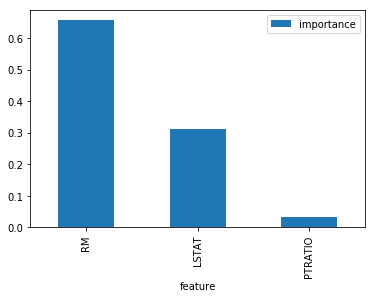

In [61]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

#Reviewer's note-check which feature is the most important
pd.DataFrame(zip(X_train.columns, reg.feature_importances_), columns=['feature', 'importance']).set_index('feature').plot(kind='bar')


** Hint: ** The answer comes from the output of the code snipped above.

**Answer: *Parameter 'max_depth' is 4 for the optimal model. This agrees with the guess in Question 6.*

### Question 10 - Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would you recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

**Hint:** Use the statistics you calculated in the **Data Exploration** section to help justify your response.  Of the three clients, client 3 has has the biggest house, in the best public school neighborhood with the lowest poverty level; while client 2 has the smallest house, in a neighborhood with a relatively high poverty rate and not the best public schools.

Run the code block below to have your optimized model make predictions for each client's home.

Predicted selling price for Client 1's home: $415,400.00
Predicted selling price for Client 2's home: $223,608.00
Predicted selling price for Client 3's home: $919,800.00
The coefficient of determination of the model is 0.7043


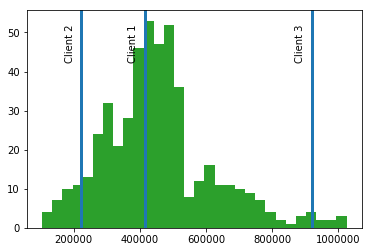

In [60]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

#From Reviewer's note, keep track of the testing error.    
print "The coefficient of determination of the model is {:,.4f}".format(reg.score(X_test,y_test))

#Check where each of the predictions falls
import matplotlib.pyplot as plt
for i,price in enumerate(reg.predict(client_data)):
    plt.hist(prices, bins = 30)
    plt.axvline(price, lw = 3)
    plt.text(price-50000, 50, 'Client '+str(i+1), rotation=90)

**Answer: * 

The coefficient of determination of the model is 0.7043, which means 70% of the variation in data can be explained by the model.With certain confident, I would recommend each client with certain price and explanation.

Client 1: $415,400. The predictd price is within one std from the mean housing price of 454k. Considering the size of the house and the relatively low poverty rate and student-teacher ratio in the neighbourhood, the price is reasonable.

Client 2: $223,608. The minimum housing price is 105k, and the 4 bedrooms adds value to the house. However, the high poverty rate and student-teacher ratio negatively impact the predicted price.

Client 3: $919,800. The predicted price is near the highest housing price in the neighbourhood of 1m. With 8 bedrooms and low poverty rate and student-teacher ratio, the price is reasonable.
*

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**

In [68]:
vs.PredictTrials(features, prices, fit_model, client_data)



Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


### Question 11 - Applicability

* In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.  

**Hint:** Take a look at the range in prices as calculated in the code snippet above. Some questions to answering:
- How relevant today is data that was collected from 1978? How important is inflation?
- Are the features present in the data sufficient to describe a home? Do you think factors like quality of apppliances in the home, square feet of the plot area, presence of pool or not etc should factor in?
- Is the model robust enough to make consistent predictions?
- Would data collected in an urban city like Boston be applicable in a rural city?
- Is it fair to judge the price of an individual home based on the characteristics of the entire neighborhood?

**Answer: *The constructed model should NOT be used in a real-world setting.

1) It is partly relevant to today's housing market prediction if taking the inflation into consideration.

2) The presented features are not sufficient to describe a home. Other factors like quality of apppliances in the home, square feet of the plot area, presence of pool or not etc should factor in.

3) The model is not robust enough to make consistent predictions. As it shown above, 10 times predictions based on different training and testing sets show difference in 15%-20% of the total predicted price. This indicates the model is not quite consistent and reliable. Adding more data point can help reduce this.

4) Data collected in an urban city is not applicable in a rural city. 

5) It is not fair to judge the price of an individual home only based on the characteristics of the entire neighborhood, however, such features should be included in the model.
*

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.